In [1]:
%pwd

u'/home/oleksandr'

In [2]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import glob
import matplotlib.pyplot as plt
import sys
# display plots in this notebook
%matplotlib inline


In [4]:

import sys
caffe_root = '/home/oleksandr/Caffe_GPU/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe

import os
if os.path.isfile(caffe_root + 
                  'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):              #'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print ('CaffeNet found.')
else:
    print ('Downloading pre-trained CaffeNet model...')
    #!../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

In [6]:
caffe.set_mode_gpu()

model_def = '/home/oleksandr/Caffe/lines/caffe_models/googlenet_02_09_2016/deploy.prototxt'                #caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = '/home/oleksandr/Caffe/lines/caffe_models/googlenet_02_09_2016/bvlc_googlenet_iter_500.caffemodel'                         #caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [7]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
#mu = np.load('/home/Caffe/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = np.load('/home/oleksandr/Caffe/lines/caffe_models/googlenet_05_09_2016/mean.npy')

mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print (type(mu))
#vgg_mu = np.array([103.939, 116.779, 123.68])
#mu = vgg_mu
print ('mean-subtracted values:', zip('BGR', mu))

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

<type 'numpy.ndarray'>
('mean-subtracted values:', [('B', 128.1980202993621), ('G', 128.33153471254258), ('R', 128.09366041535594)])


In [8]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          224, 224)  # image size is 227x227

In [9]:
#image_path = '/home/oleksandr/Desktop/rims.vm.pbank.com.ua/tmp/AllPhotos/all_imges/'
image_path = '/home/oleksandr/Desktop/rims.vm.pbank.com.ua/tmp/AllPhotos/all_imges/'
images = []
for filename in glob.iglob(image_path + '*.jpg'):
    images.append(filename)
print (len(images))
#im_arr = np.array(images)

#image_path = '/home/oleksandr/Caffe/deeplearning-cats-dogs-tutorial/input/train/'
#image_path = '/home/oleksandr/Caffe/lines/queue_color_photos_6k/'
#images = glob.iglob(image_path + '*.jpg')

labels = [1- int("noqueue" in filename) for filename in images]
print (len(labels))
#images = glob.iglob(image_path + '*.jpg')
#cams = [int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images]
cams = np.array([int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images])
print (type(cams[0]))
print (len(cams))
#print (np.array(labels)[cams==cam])
# удаляем картинкы с камер, по которым нет ни одной очереди

null_cams=[cam for cam in set(cams) if sum(np.array(labels)[cams==cam])==0]
#print len(null_cams)
images = [im for i,im in enumerate(images) if cams[i] not in null_cams]
print (len(images))
# пересчитываем по новому набору картинок
labels = np.array([1- int("noqueue" in filename) for filename in images])
cams = np.array([int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images])
dates= np.array([[filename[filename.find('_date_')+6:filename.find('.jpg')] for filename in images]])
    

53613
53613
<type 'numpy.int64'>
53613
42779


In [47]:
images[80]
import copy
images_1 = copy.deepcopy(images)

In [10]:
#dates = dates.reshape(5813,1)
#labels = labels.reshape(5813, 1)
#cams = cams.reshape(5813,1)
#print (labels.shape)
#print (cams.shape)
#print (dates.shape)

#a = np.hstack((labels, cams, dates))
#print (a.shape)
#with open("pool_5_labels.csv", 'w') as output_file:
#        np.savetxt(output_file, a, delimiter=";", fmt='%s')
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print (layer_name + '\t' + str(blob.data.shape))

data	(1, 3, 224, 224)
conv1/7x7_s2	(1, 64, 112, 112)
pool1/3x3_s2	(1, 64, 56, 56)
pool1/norm1	(1, 64, 56, 56)
conv2/3x3_reduce	(1, 64, 56, 56)
conv2/3x3	(1, 192, 56, 56)
conv2/norm2	(1, 192, 56, 56)
pool2/3x3_s2	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_0	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_1	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_2	(1, 192, 28, 28)
pool2/3x3_s2_pool2/3x3_s2_0_split_3	(1, 192, 28, 28)
inception_3a/1x1	(1, 64, 28, 28)
inception_3a/3x3_reduce	(1, 96, 28, 28)
inception_3a/3x3	(1, 128, 28, 28)
inception_3a/5x5_reduce	(1, 16, 28, 28)
inception_3a/5x5	(1, 32, 28, 28)
inception_3a/pool	(1, 192, 28, 28)
inception_3a/pool_proj	(1, 32, 28, 28)
inception_3a/output	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_0	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_1	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_2	(1, 256, 28, 28)
inception_3a/output_inception_3a/output_0_split_3	(1, 256, 28, 28)


In [ ]:
count = 0
for indx, image in enumerate(images_1):
    if 0 < int(image[-12:-10]) < 6:
        print (int(image[-12:-10]) + 12)
        new_str = images_1[indx][:-12] + str(int(image[-12:-10]) + 12) + images_1[indx][-10:] #+ str(int(image[-12:-10]) + 12)
        print (new_str)
        images_1[indx] = new_str
        count += 1
        print (images_1[indx])

In [78]:
print(count)
#labels = np.array([1- int("noqueue" in filename) for filename in images])
#cams = np.array([int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images])
#dates= np.array([[filename[filename.find('_date_')+6:filename.find('.jpg')] for filename in images_1]])
print (dates[:,0])

14884
['2016-08-25_13_43_09']


0
8637


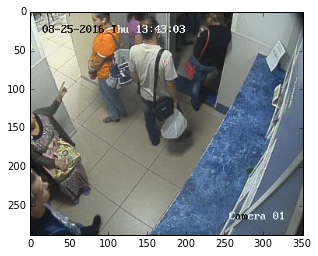

In [20]:
#lb = np.loadtxt(open("pool_5_labels.csv","r"), dtype=str, delimiter=";")
#with open("images_19_08_16.csv", 'a') as output_file:
#            np.savetxt(output_file,
#                   im_arr,
#                   delimiter=";", fmt='%s')
from __future__ import print_function
#print (images_1[0])
print (labels[0])
print (cams[3])
#print (dates[:, 100])
image = caffe.io.load_image(images[0])
plt.imshow(image)
with open('pool_s2_labels_08_09_16_googlenet_test.csv', 'w') as ooo:
    for i in range(len(images)):
        print (str(labels[i]) + ';' + str(cams[i]) + ';' + str(dates[:, i][0]), file=ooo)
file_1 = open('pool_s2_labels_08_09_16_googlenet_test.csv', 'r') 
#for image in file_1:
#    if '2016-08-25_01_43_09' in images:
#        print (image)
#lines = []
#for line in file_1:
#    lines.append(line)
#print (len(lines))


In [ ]:
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
tsvd = TruncatedSVD(n_components=2048)
Scaler=StandardScaler()
from __future__ import print_function
#pca = RandomizedPCA(n_components=2048)
batch_size=2000
first_time=True
features_array = np.zeros((batch_size, 1*832*7*7))

for j,filename in enumerate(images):
    counter = j % batch_size
    print (counter, end = ' ')
        
    image = caffe.io.load_image(filename)
    transformed_image = transformer.preprocess('data', image)
    #print transformed_image.shape
    # copy the image data into the memory allocated for the net
    net.blobs['data'].data[...] = transformed_image

    ### perform classification
    output = net.forward()

    output_prob = output['prob'][0]  # the output probability vector for the first image in the batch


    feat = net.blobs['pool4/3x3_s2'].data.copy()
    #print (feat.shape)
    #print (features_array[counter].shape)
    features_array[counter] = feat.reshape(1*832*7*7)

    if counter == batch_size-1 or j==len(images)-1:
        #print ('go to pca')
        #if first_time:
         #   Scaler.fit(features_array)
         #   print ("done!")
         #   tsvd.fit(Scaler.transform(features_array))
         #   first_time = False
    
        #X_train_pca = tsvd.transform(Scaler.transform(features_array))
        X_train_pca = features_array
        print ('X_train_pca ', X_train_pca.shape)
        
        
        #if first_time:
        #    pca.fit(features_array)
        #    print ("done!")
        #    print (sum(pca.explained_variance_ratio_)) # эту цифру мне скажи
        #    first_time = False
    
        #X_train_pca = pca.transform(features_array)
        #print (j,counter,'X_train_pca ', X_train_pca.shape)
    
        with open("pool4_s2_08_09_16_goolenet_test.csv", 'a') as output_file:
            np.savetxt(output_file,
                   [X_train_pca[i] for i in range(counter+1)],
                  delimiter=";", fmt='%2.2f')
       
        #with open("pool_5_lines_19_08_16_trunc.csv", 'a') as output_file:
        #    np.savetxt(output_file,
        #           [features_array[i] for i in range(counter+1)],
        #           delimiter=";", fmt='%2.2f')
       

In [30]:
b = np.loadtxt(open("/home/oleksandr/Desktop/pool_s2_labels_08_09_16_googlenet_test.csv","r"), dtype=str, delimiter=";")

In [33]:
b_labels = np.loadtxt(open("pool5_7x7_s1_labels_06_09_16_alexnet_test.csv","r"), dtype=str , delimiter=";")

In [34]:
print (b.shape)
print (b_labels.shape)
#np.savetxt('pool5_labels_05', b_labels,
#                  delimiter=";", fmt="%s")

(42779, 3)
(815, 5)


In [11]:
def classify_images(y_pred):
    for image in images:
        image = caffe.io.load_image(image)
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image
        output = net.forward()
        output_prob = output['prob'][0]
        #net_labels.append(output_prob.argmax())
        y_pred.append(output_prob.argmax())
        print (output_prob.argmax(), end= ' ')

y_pred = []
classify_images(y_pred)

SyntaxError: invalid syntax (<ipython-input-11-93cc16cbff23>, line 10)

In [49]:
with open('test_labels_06_09_2016.csv', 'w') as out_file:
    #out_file.write("\n".join(y_pred))
    for item in y_pred:
        out_file.write("%s\n" % item)
    #outfile.write("\n".join(itemlist))


In [32]:
b.shape

(42779, 3)

In [6]:
sum(y_pred)
from sklearn.metrics import classification_report
print(classification_report(labels, y_pred))

u'/home/oleksandr'

In [ ]:
#image_path = '/home/oleksandr/Caffe/deeplearning-cats-dogs-tutorial/input/train/'
image_path = '/home/oleksandr/Caffe/lines/queue_color_photos_6k/'
images = glob.iglob(image_path + '*.jpg')
labels = [1- int("noqueue" in filename) for filename in images]
cams = [int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images]

# удаляем картинкы с камер, по которым нет ни одной очереди
null_cams=[cam for cam in set(cams) if sum(np.array(labels)[cams==cam])==0]
print len(null_cams)
images = [im for i,im in enumerate(images) if cams[i] not in null_cams]

# пересчитываем по новому набору картинок
labels = [1- int("noqueue" in filename) for filename in images]
cams = [int(filename[filename.find('_cam_')+5:filename.find('_date_')]) for filename in images]
dates= [[filename[filename.find('_date_')+6:filename.find('.jpg')] for filename in images]]

